In [93]:
%reset -fs

In [94]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

To-do:
- Load data
- Categorize pitches
- Categorize outcomes
- Establish features
- Train RF model for each pitch type

Concat all .csv files for 2021's regular season

In [95]:
columns = ['date', 't1', 'pitcher', 't2', 'batter', 'inning', 'result', 'pitch_type', 
           'mph', 'rpm', 'vbreak', 'up_down', 'hbreak', 'left_right', 'count']
df = pd.DataFrame(columns = columns)
# Reading in all csvs and appending to one dataframe
for month in range(4, 11):
    print(month)
    files = os.listdir(str(month) + '/')
    df_month = pd.concat([pd.read_csv(str(month) + '/' + file, index_col = 0) for file in files if file.endswith('.csv')], ignore_index = True)
    if len(df) == 0:
        df = df_month
    else:
        df = pd.concat([df, df_month], ignore_index = True)
    
            

4
5
6
7
8
9
10


Pitch types:
- 4-Seam Fastball
- Slider
- Sinker
- Changeup
- Curveball
- Cutter
- Knuckle Curve
- Splitter
- Fastball
- Slow Curve
- Eephus
- Knucle Ball

Groups:
- 4-Seam/Fastball
- Slider
- Sinker
- Changeup
- Curve/Knuckle Curve/Slow Curve
- Knuckle Ball/ Splitter
- Cutter

Result types:
- Ball
- Foul
- Called Strike
- Swinging Strike
- In play, out(s)
- In play, no out
- Ball in Dirt
- In play, run(s)
- Foul Tip
- Hit By Pitch
- Foul Bunt
- Missed Bunt
- Pitchout

Groups:
- Strikes
- Balls - Filter out
- Contact
- Fouls - Filter out

Very important -- make sure numeric values are read as numeric!

In [96]:
df['rpm'] = df['rpm'].apply(int)
df['vbreak'] = df['vbreak'].apply(int)
df['hbreak'] = df['hbreak'].apply(int)

In [97]:
df['left_right'].value_counts()

←    327578
→    260159
Name: left_right, dtype: int64

In [98]:
df['left_right'] = df['left_right'].apply(lambda x: x == '←')

Grouping results and pitch types

In [99]:
result_dict = {'Ball': 'Ball',
               'Foul': 'Foul',
               'Called Strike': 'Strike',
               'Swinging Strike': 'Strike',
               'In play, out(s)': 'Contact',
               'In play, no out': 'Contact',
               'Ball In Dirt': 'Ball',
               'In play, run(s)': 'Contact',
               'Foul Tip': 'Strike',
               'Hit By Pitch': 'Ball',
               'Foul Bunt': 'Strike',
               'Missed Bunt': 'Strike',
               'Pitchout': 'Ball'}

In [100]:
def group_pitches(x):
    if 'Fastball' in x:
        return 'Fastball'
    elif 'Curve' in x:
        return 'Curveball'
    elif ('Knuc' in x) or (x == 'Splitter'):
        return 'Splitter'
    else:
        return x


In [101]:
df['result'].value_counts()

Ball               201182
Foul               107570
Called Strike       99187
Swinging Strike     68763
In play, out(s)     67077
In play, no out     23025
Ball In Dirt        14730
In play, run(s)     13612
Foul Tip             5782
Hit By Pitch         1784
Foul Bunt            1302
Missed Bunt           311
Pitchout               25
Foul Pitchout           1
Name: result, dtype: int64

In [102]:
df['result'] = df['result'].map(result_dict)
df['pitch_type'] = df['pitch_type'].apply(group_pitches)

In [103]:
df['result'].value_counts()

Ball       217721
Strike     175345
Foul       107570
Contact    103714
Name: result, dtype: int64

Only keeping pitches that resulted in 'Strike' or 'Contact'

In [104]:
df = df.dropna()
df = df.loc[(df['result'] == 'Strike') | (df['result'] == 'Contact')]
codes, uniques = pd.factorize(df['result'])
df['result'] = codes

In [106]:

pitch_types = ['Fastball', 'Slider', 'Sinker', 'Changeup', 'Curveball', 'Splitter', 'Cutter']
#pitch_type = pitch_types[1]



Features:
- MPH
- RPM
- VBreak
- HBreak
- Break is Left

In [107]:
from joblib import dump

In [110]:
from sklearn.metrics import f1_score

In [140]:
# The depth of the trees for each model. These are selected for by finding the inflection point for accuracy and F1
depth_dict = {
    'Fastball':15,
    'Slider':17,
    'Sinker':13,
    'Changeup':7,
    'Curveball':15,
    'Splitter':13,
    'Cutter':11,
}

In [148]:
# Training RF for each pitch type, then saving the file to disk
for pitch_type in pitch_types:
    df_filter = df.loc[df['pitch_type'] == pitch_type]
    X = df_filter[['mph', 'rpm', 'vbreak', 'hbreak', 'left_right']]
    y = df_filter['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)
    estimators = 128
    max_depth = 11
    # Be sure to weight classes appropriately to improve F1
    rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth, criterion = 'entropy',
                               class_weight = {0:y_test.mean(),1:1-y_test.mean()})
    scores = cross_val_score(rf, X_train, y_train, cv = 5)
    #print(f'Estimators: {estimators}')
    #print(f'Max depth: {max_depth}')
    #print(f'Cross val score: {scores.mean()}')
    rf.fit(X_train, y_train)
    print(f'Mean: {rf.predict_proba(X_test)[:,0].mean()}')
    print(f'Min: {rf.predict_proba(X_test)[:,0].min()}')
    print(f'Max: {rf.predict_proba(X_test)[:,0].max()}')
    print(f'F1 score: {f1_score(y_test, rf.predict(X_test))}')
    print(f'Random Forest val score for {pitch_type}: {rf.score(X_test, y_test):.3f}')
    print('---')
    dump(rf, pitch_type + '2.rf')

Mean: 0.5078805628525402
Min: 0.07510830818618985
Max: 0.9055503086368138
F1 score: 0.4638751058937432
Random Forest val score for Fastball: 0.536
---
Mean: 0.5084689373874789
Min: 0.13754275054255083
Max: 0.88512401509218
F1 score: 0.42672820727997485
Random Forest val score for Slider: 0.510
---
Mean: 0.5110198145302014
Min: 0.3002856629729655
Max: 0.850185208382503
F1 score: 0.49655827201519104
Random Forest val score for Sinker: 0.530
---
Mean: 0.500559539905414
Min: 0.21910814136620996
Max: 0.9551131460569933
F1 score: 0.49941067519784477
Random Forest val score for Changeup: 0.517
---
Mean: 0.5251771466119994
Min: 0.20850899879659107
Max: 0.923857548062386
F1 score: 0.3615363953800698
Random Forest val score for Curveball: 0.588
---
Mean: 0.5198740025423233
Min: 0.15372710162646666
Max: 0.8813548586460822
F1 score: 0.4260355029585799
Random Forest val score for Splitter: 0.533
---
Mean: 0.5194904112052127
Min: 0.262804706122096
Max: 0.9523877179303541
F1 score: 0.4557495484647803

Model Scores:
- Fastball: .633
- Slider: 0.672
- Sinker 0.579
- Changeup 0.569
- Curve/Knuckle Curve/Slow Curve 0.683
- Knuckle Ball/ Splitter 0.623
- Cutter 0.614

Model V2 Scores (acc/F1):
- Fastball: .603/.318
- Slider: 0.647/.226
- Sinker 0.552/.387
- Changeup 0.545/.414
- Curve/Knuckle Curve/Slow Curve 0.659/.190
- Knuckle Ball/ Splitter 0.605/.347
- Cutter 0.559/.346

In [133]:
rf.predict_proba(X_test)[:,0].mean()
rf.predict_proba(X_test)[:,0].max()
rf.predict_proba(X_test)[:,0].min()


array([0.41799957, 0.46875   , 0.59479242, ..., 0.25572917, 0.52326679,
       0.7578125 ])

(array([ 31.,  88., 224., 381., 538., 791., 756., 590., 299.,  89.]),
 array([0.08590411, 0.17591123, 0.26591835, 0.35592547, 0.44593259,
        0.53593971, 0.62594683, 0.71595395, 0.80596106, 0.89596818,
        0.9859753 ]),
 <BarContainer object of 10 artists>)

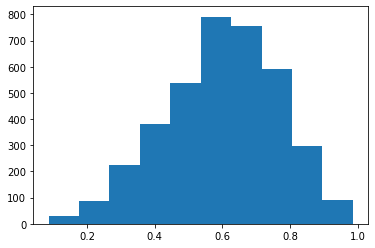

In [134]:
import matplotlib.pyplot as plt
plt.hist(rf.predict_proba(X_test)[:,0])